In [54]:
#%pip install --upgrade jax jaxlib
#%pip install --upgrade blackjax

In [77]:
import jax
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
import blackjax
import numpy as np
import jax.numpy as jnp

### Definition of the MCLMC Sampler

In [83]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform):
    
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda sqrt_diag_cov : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        sqrt_diag_cov=sqrt_diag_cov,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    print("L:", blackjax_mclmc_sampler_params.L)
    print("step_size:", blackjax_mclmc_sampler_params.step_size)
    

    # run the sampler
    _, samples, _ = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples

### 2D Regression

In [84]:

from jax.scipy.stats import norm, uniform
import edudat
from edudat import load_data
df = load_data('sbp.csv', verbose=True)
print(df.head())
x = df['x'].values
y = df['y'].values
N = len(x)

def logdensity_fn(a,b,sigma):
    """
    Log density function for a linear regression model with uniform priors.
    
    Args:
    theta (array): An array of parameters [a, b, sigma].
    
    Returns:
    float: The log probability density of the model given the data.
    """
    
    # Prior distributions for a, b, and sigma
    log_prior_a = norm.logpdf(a, 0, 10) # uniform prior on a between -100,100
    log_prior_b = norm.logpdf(b, 0, 10)
    log_prior_sigma = uniform.logpdf(sigma, 0.1, 100)
    #print(log_prior_a, jnp.exp(log_prior_b), log_prior_sigma)
    
    # The likelihood of the data given the model
    log_likelihood = jnp.sum(norm.logpdf(y, a * x + b, sigma))
    
    # Sum of log prior probabilities and the log likelihood
    log_posterior = log_prior_a + log_prior_b + log_prior_sigma + log_likelihood
    return log_posterior

logdensity_fn(0,0,1.) # R Code -328281.9

logdensity = lambda x: logdensity_fn(**x)

# run the algorithm on a high dimensional gaussian, and show two of the dimensions
sample_key, rng_key = jax.random.split(rng_key)


initial_position = {'a': 0., 'b': 0., 'sigma': 1.}
samples = run_mclmc(
    logdensity_fn=logdensity,
    num_steps=10000,
    initial_position=initial_position,
    key=sample_key,
    transform=lambda x: x,
)
print(samples.position['a'][500:].mean(), samples.position['b'][500:].mean(), samples.position['sigma'][500:].mean())




Using cached sbp.csv
    x    y
0  22  131
1  41  139
2  52  128
3  23  128
4  41  171
L: 4.531882
step_size: 0.1656774


2.2168925 29.928576 28.883316


In [80]:
#Adapter from https://blackjax-devs.github.io/sampling-book/models/change_of_variable_hmc.html
def arviz_trace_from_states(states, burn_in=0):
    position = states.position
    if isinstance(position, jax.Array):  # if states.position is array of samples
        position = dict(samples=position)
    else:
        try:
            position = position._asdict()
        except AttributeError:
            pass

    samples = {}
    for param in position.keys():
        ndims = len(position[param].shape)
        if ndims >= 2:
            samples[param] = jnp.swapaxes(position[param], 0, 1)[
                :, burn_in:
            ]  # swap n_samples and n_chains

        if ndims == 1:
            samples[param] = position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace = az.concat(trace_posterior)
    return trace

** Important note on the traceplots and n_eff values: **

When comparing with HMC, we here see the leapfrog steps, thus it is quite natural not to see a hairy catapilar.

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.277,0.250,1.778,2.717,0.036,0.025,49.0,132.0,NaN
b,26.890,11.796,4.361,48.420,1.877,1.337,39.0,55.0,NaN
sigma,28.923,4.781,21.491,39.362,0.582,0.416,71.0,136.0,NaN


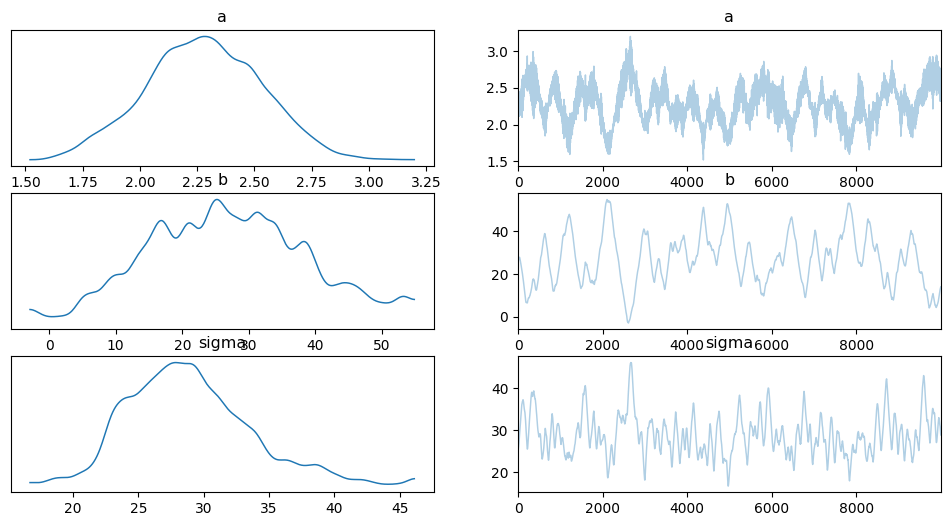

In [82]:
import arviz as az
trace = arviz_trace_from_states(samples, burn_in=1000)
arcviz.plot_trace(trace, compact=True)

az.summary(trace)